# Qiskit Modules Demo

In [1]:
!python -m pip install --upgrade pip

In [2]:
!python -m pip install qiskit qiskit-aer pylatexenc matplotlib sympy graphviz qiskit-ibm-runtime seaborn

In [75]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/' 
# Replace with the path to your Graphviz binary (get from https://graphviz.org/download/)

## 1) Importing Dependencies

In [4]:
# Core circuit
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit.circuit.library import PauliEvolutionGate

# Quantum info
from qiskit.quantum_info import Statevector, SparsePauliOp, Operator, DensityMatrix

# Converters
from qiskit.converters import circuit_to_dag, dag_to_circuit

# Transpiler + Target
from qiskit.transpiler import generate_preset_pass_manager, Target, InstructionProperties
from qiskit.circuit.library import RXGate, RZGate, CXGate, Measure

# Visualization
from qiskit.visualization import plot_histogram, pass_manager_drawer, plot_state_city, plot_state_hinton, plot_gate_map, plot_state_paulivec, plot_coupling_map, plot_error_map, plot_circuit_layout

# Qiskit IBM Runtime
from qiskit_ibm_runtime import EstimatorV2
from qiskit_ibm_runtime.fake_provider import FakeManilaV2, FakeWashingtonV2

# Qiskit-Aer
from qiskit_aer import AerSimulator

# Primitives
from qiskit.primitives import StatevectorSampler, StatevectorEstimator

import numpy as np

## 2) Build a Parameterized Physical Model (Simulating 4-Qubit Heisenberg Hamiltonian Evolution) 

The Heisenberg Hamiltonian describes how quantum spins interact with one another in a many-body system. It is a fundamental model in condensed matter physics and can be used to simulate magnetic materials, quantum phases of matter, and certain chemical systems.

In simple terms: Any physical quantum system starts off in a specific initial state/configuration (spin up/down is $|0\rangle$/$|1\rangle$). Then the Hamiltonian (H) describes how the system evolves over time (t) to the final state/configuration of the system.

We will simulate a simple XX + ZZ interaction on 4 qubits.

The Hamiltonian matrix for this would be:
$H = \sum_{i=0}^{2} \left( X_i X_{i+1} + Z_i Z_{i+1} \right)$

(Which describes how the system evolves over time, assuming adjacent qubits interact by bit/phase flips alone)

Note for later: After simulating the evolution of the system, we can obtain the average energy level of the quantum system by finding the expectation value of the Hamiltonian (for the state at time t).

In [5]:
n = 4
t = Parameter("t")

# Build Hamiltonian using SparsePauliOp (memory efficient)
paulis = []
for i in range(n - 1):
    xx = ["I"] * n
    zz = ["I"] * n
    xx[i] = "X"
    xx[i+1] = "X"
    zz[i] = "Z"
    zz[i+1] = "Z"
    
    paulis.append(("".join(xx), 1.0))
    paulis.append(("".join(zz), 1.0))

H = SparsePauliOp.from_list(paulis)

H

SparsePauliOp(['XXII', 'ZZII', 'IXXI', 'IZZI', 'IIXX', 'IIZZ'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])

So We have successfully created the Hamiltonian $H = XXII + ZZII + IXXI + IZZI + IIXX + IIZZ$

## 3) Building the Quantum Circuit Corresponding to this Hamiltonian

We now create a quantum circuit which implements this Hamiltonian Evolution.

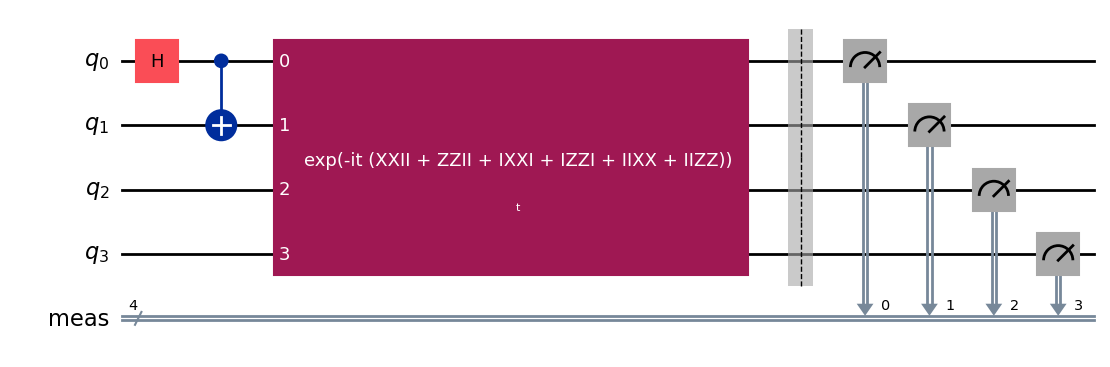

In [6]:
evo_gate = PauliEvolutionGate(H, time=t) # For now, we leave t (time over which the system evoloves) as a parameter 

qc = QuantumCircuit(n)
qc.h(0)
qc.cx(0,1)
qc.append(evo_gate, range(n))
qc.measure_all()

qc.draw("mpl")

## 4) Assigning Time Parameter and Simulating the Circuit (using State vectors)

We have a specific circuit, but to actually run the simulation (execute the circuit), we need to assign a value to the time parameter (t) 

In [7]:
qc_assigned = qc.assign_parameters({t: 0.7}) # Assigning t = 0.7 before executing the circuit

qc_no_meas = qc_assigned.remove_final_measurements(inplace=False)
sv = Statevector.from_instruction(qc_no_meas)
sv

Statevector([-0.62645606-0.24751099j,  0.        +0.j        ,
              0.        +0.j        ,  0.06381071-0.24322875j,
              0.        +0.j        ,  0.03114969-0.12180762j,
             -0.3139837 -0.12180762j,  0.        +0.j        ,
              0.        +0.j        , -0.11026731+0.12005299j,
             -0.17256669+0.12005299j,  0.        +0.j        ,
             -0.34662294+0.23796486j,  0.        +0.j        ,
              0.        +0.j        , -0.22202418+0.23873784j],
            dims=(2, 2, 2, 2))


C:\Users\drarc\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
C:\Users\drarc\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\scipy\sparse\linalg\_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)


In [8]:
sv.draw('latex') # Using quantum_info methods to see the symbolic expression

<IPython.core.display.Latex object>

* So far: We have simulated the evolution of the quantum system's state over time t.
* Now: We want to estimate the average energy of the quantum system after evolving for time t (What the theoretical value *should* be).
This is so that later, when we actually execute the circuit on some hardware backend, we can verify if our answers are correct.

In [9]:
estimator = StatevectorEstimator() # Used to estimate the Hamiltonian (energy level) using the Statevector (without actually running the circuit)

job = estimator.run([(qc_no_meas, H)])
result = job.result()

result[0].data.evs

C:\Users\drarc\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
C:\Users\drarc\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\scipy\sparse\linalg\_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)


array(3.)

So we see at `t=0.7`, the average energy of the quantum system is `3` units (depending on the units H is expressed in).

Now, we want to `transpile` the circuit to a `Target` backend and actually execute the circuit.

## 5) Under the Hood: A look at DAGCircuit

In [10]:
# Converting the quantum circuit (Python) to a DAG (Rust)
dag = circuit_to_dag(qc_assigned)

print("Number of DAG nodes:", len(list(dag.op_nodes())))
print("\nTopological order:")
for node in dag.topological_op_nodes():
    print(node.name)

Number of DAG nodes: 8

Topological order:
h
cx
PauliEvolution
barrier
measure
measure
measure
measure


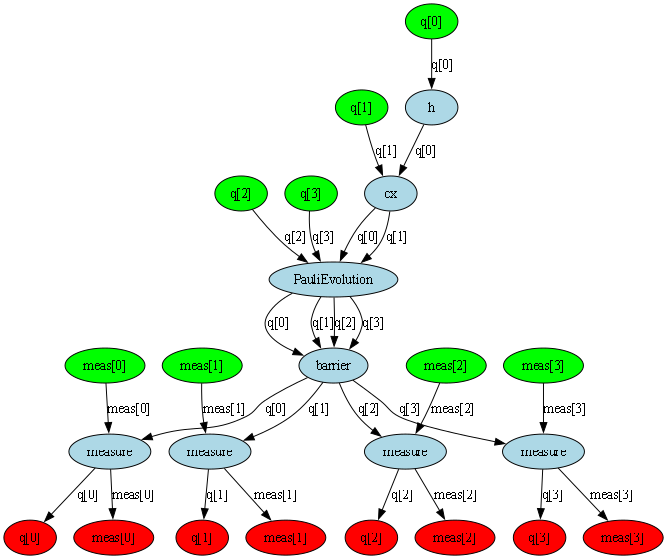

In [11]:
dag.draw()

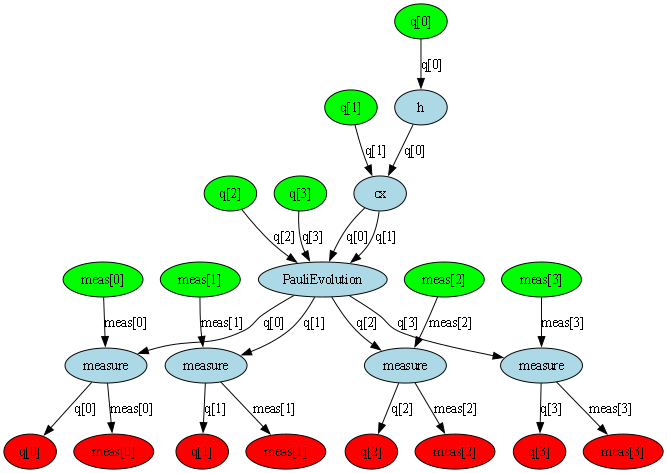

In [14]:
# Remove all barriers
dag.remove_all_ops_named("barrier")
dag.draw()

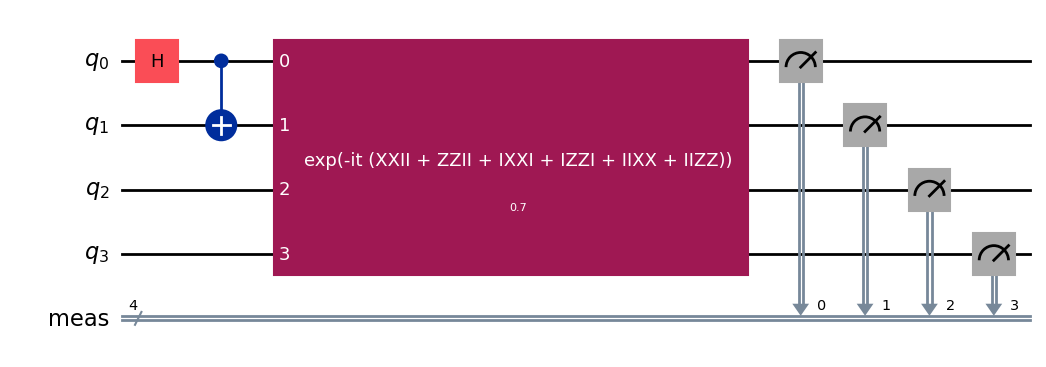

In [15]:
# Converting back to a circuit to see changes
new_qc = dag_to_circuit(dag)
new_qc.draw("mpl")

## 6) Define a Custom Target (Hardware Contract)

Though there exist several pre-defined backends (simulators and real QPUs), we have a breif look at how we may define our own custom hardware `Target` backends.

We are making a simple 4-qubit architecture with single qubit Rx/Rz operations and CX operations only.

In [16]:
target = Target(num_qubits=4)

# Properties of the Rx and Rz gates:
rx_props = {
    (q,): InstructionProperties(duration=25e-9, error=1e-4)
    for q in range(4)
}
rz_props = {
    (q,): InstructionProperties(duration=20e-9, error=5e-5)
    for q in range(4)
}

# Add the Rx and Rz gates (with properties) to the instruction set of our custom Target
target.add_instruction(RXGate(np.pi/6), rx_props)
target.add_instruction(RZGate(np.pi/4), rz_props)

# Add CX gates between neighbouring qubits to the Target instruction set:
cx_props = {
    (0,1): InstructionProperties(duration=300e-9, error=2e-3),
    (1,2): InstructionProperties(duration=300e-9, error=2e-3),
    (2,3): InstructionProperties(duration=300e-9, error=2e-3),
}
target.add_instruction(CXGate(), cx_props)

In [17]:
target

In [18]:
target.operation_names

dict_keys(['rx', 'rz', 'cx'])

In [19]:
target.instructions

[(Instruction(name='rx', num_qubits=1, num_clbits=0, params=[0.5235987755982988]),
  (0,)),
 (Instruction(name='rx', num_qubits=1, num_clbits=0, params=[0.5235987755982988]),
  (1,)),
 (Instruction(name='rx', num_qubits=1, num_clbits=0, params=[0.5235987755982988]),
  (2,)),
 (Instruction(name='rx', num_qubits=1, num_clbits=0, params=[0.5235987755982988]),
  (3,)),
 (Instruction(name='rz', num_qubits=1, num_clbits=0, params=[0.7853981633974483]),
  (0,)),
 (Instruction(name='rz', num_qubits=1, num_clbits=0, params=[0.7853981633974483]),
  (1,)),
 (Instruction(name='rz', num_qubits=1, num_clbits=0, params=[0.7853981633974483]),
  (2,)),
 (Instruction(name='rz', num_qubits=1, num_clbits=0, params=[0.7853981633974483]),
  (3,)),
 (Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), (0, 1)),
 (Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), (1, 2)),
 (Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), (2, 3))]

In [20]:
coupling_map = target.build_coupling_map()
print(coupling_map)

[[0, 1], [1, 2], [2, 3]]


## 7) Transpilation at Different Optimization Levels

In [21]:
# Default Qiskit Transpiler Pass Managers (at optimization_level 0/1/2/3)
pm0 = generate_preset_pass_manager(optimization_level=0, target=target)
pm1 = generate_preset_pass_manager(optimization_level=1, target=target)
pm2 = generate_preset_pass_manager(optimization_level=2, target=target)
pm3 = generate_preset_pass_manager(optimization_level=3, target=target)

In [22]:
# Running the transpiler on the same circuit before and after
t0 = pm0.run(qc_no_meas)
t1 = pm1.run(qc_no_meas)
t2 = pm2.run(qc_no_meas)
t3 = pm3.run(qc_no_meas)

In [23]:
# An Equivalent Syntax (if you want to use the default Qiskit Pass Managers)
t0 = transpile(qc_no_meas, target=target, optimization_level=0)
t1 = transpile(qc_no_meas, target=target, optimization_level=1)
t2 = transpile(qc_no_meas, target=target, optimization_level=2)
t3 = transpile(qc_no_meas, target=target, optimization_level=3)

In [26]:
# Effects of optimization:
for i, circ in enumerate([t0,t1, t2, t3], start=1):
    print(f"\nOptimization Level {i-1}")
    print("Depth:", circ.depth())
    print("Size:", circ.size())
    print("Gate count:", circ.count_ops())


Optimization Level 0
Depth: 36
Size: 58
Gate count: OrderedDict({'rz': 32, 'rx': 13, 'cx': 13})

Optimization Level 1
Depth: 36
Size: 58
Gate count: OrderedDict({'rz': 32, 'rx': 13, 'cx': 13})

Optimization Level 2
Depth: 24
Size: 47
Gate count: OrderedDict({'rz': 23, 'rx': 17, 'cx': 7})

Optimization Level 3
Depth: 24
Size: 47
Gate count: OrderedDict({'rz': 23, 'rx': 17, 'cx': 7})


* We can see that higher optimization levels result in better, more efficient circuits (with smaller depth and gate counts)
* In this case, we have a small circuit and `Target` with a very simple gate set (with smaller scope for optimizations).
* For much larger and practical circuits and modern hardware with richer gate sets, the effect of optimization levels in the transpiler is much more drastic.
* Now, let us have a look at how each of the transpiled circuits look...

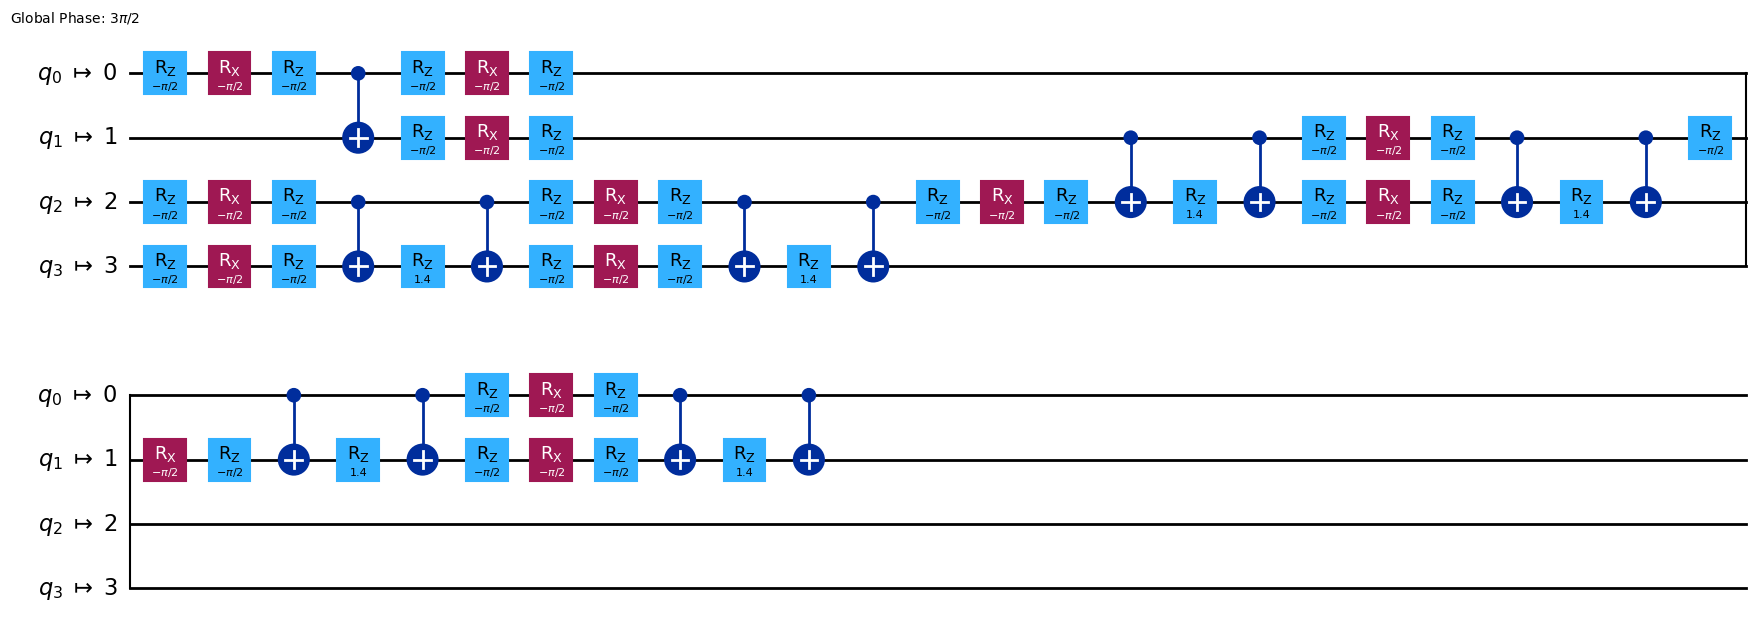

In [27]:
t1.draw("mpl")

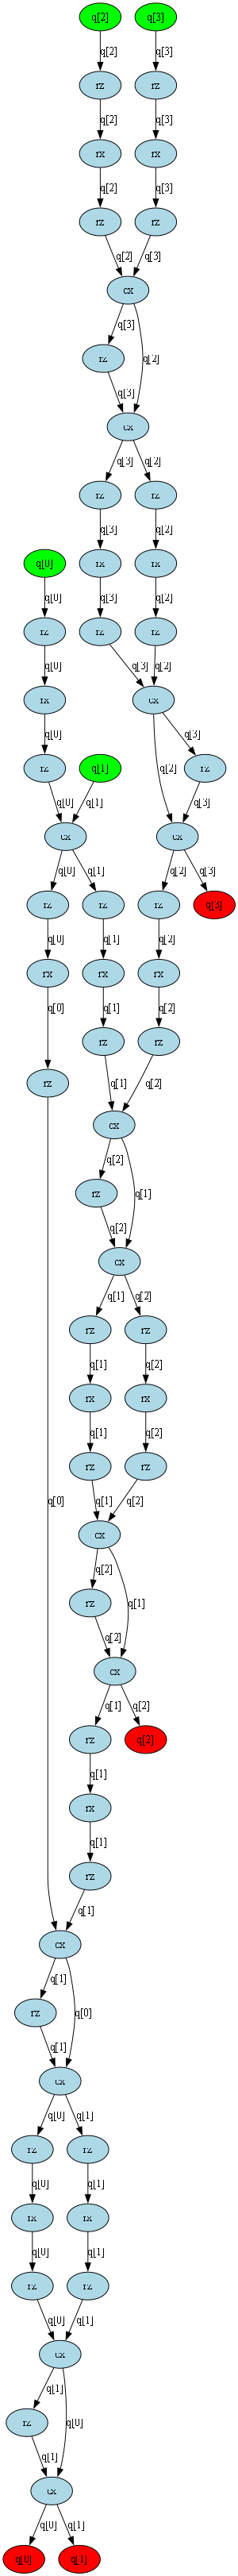

In [28]:
dag1 = circuit_to_dag(t1)
dag1.draw()

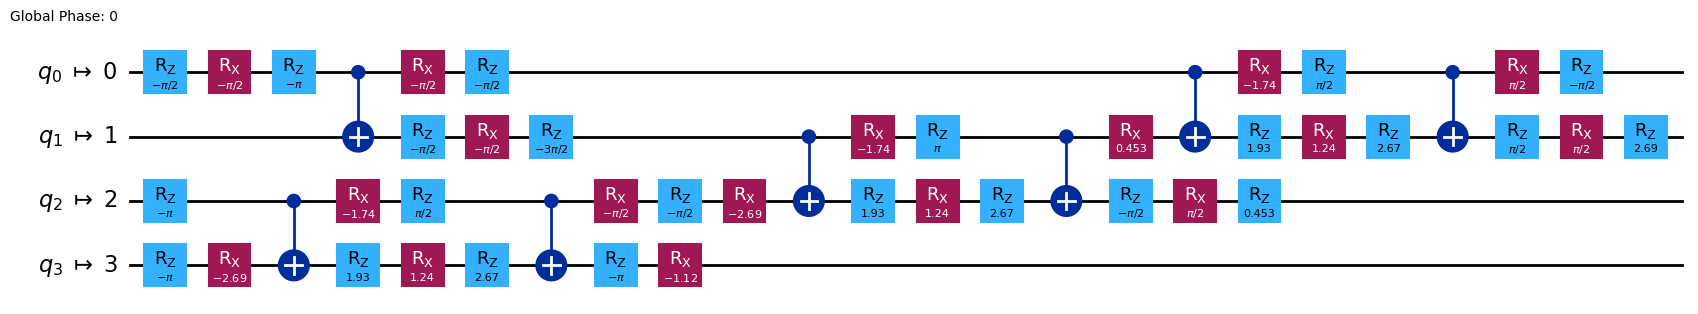

In [29]:
t3.draw("mpl")

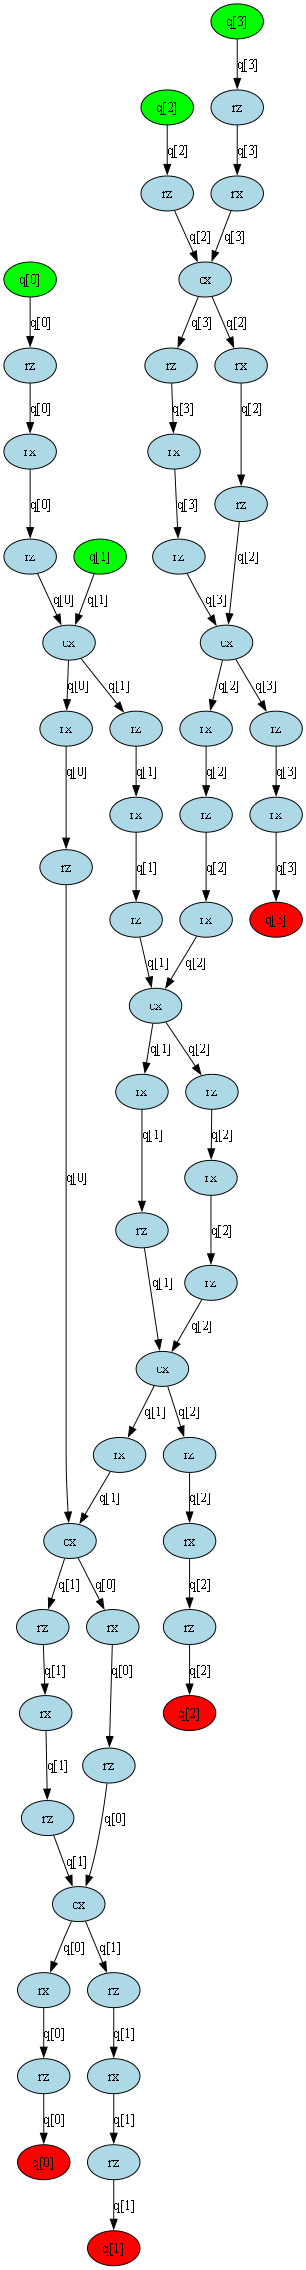

In [30]:
dag3 = circuit_to_dag(t3)
dag3.draw()

## 8) Running on a Fake Backend

* Just as an exercize, we defined our own custom (although primitive) Target.
* Now let us transpile and run our circuit on a more realistic, practical backend.

In [31]:
# Create fake backend
backend = FakeManilaV2()

# Transpile at different optimization levels:
qc_transpiled_0 = transpile(qc_no_meas, backend, optimization_level=0)
qc_transpiled_1 = transpile(qc_no_meas, backend, optimization_level=1)
qc_transpiled_2 = transpile(qc_no_meas, backend, optimization_level=2)
qc_transpiled_3 = transpile(qc_no_meas, backend, optimization_level=3)

Visualizing the effects of transpilation (as earlier):

In [32]:
# Effects of optimization:
for i, circ in enumerate([qc_transpiled_0,qc_transpiled_1, qc_transpiled_2, qc_transpiled_3], start=1):
    print(f"\nOptimization Level {i-1}")
    print("Depth:", circ.depth())
    print("Size:", circ.size())
    print("Gate count:", circ.count_ops())


Optimization Level 0
Depth: 36
Size: 58
Gate count: OrderedDict({'rz': 32, 'sx': 13, 'cx': 13})

Optimization Level 1
Depth: 36
Size: 58
Gate count: OrderedDict({'rz': 32, 'sx': 13, 'cx': 13})

Optimization Level 2
Depth: 24
Size: 44
Gate count: OrderedDict({'rz': 22, 'sx': 13, 'cx': 7, 'x': 2})

Optimization Level 3
Depth: 24
Size: 44
Gate count: OrderedDict({'rz': 22, 'sx': 13, 'cx': 7, 'x': 2})


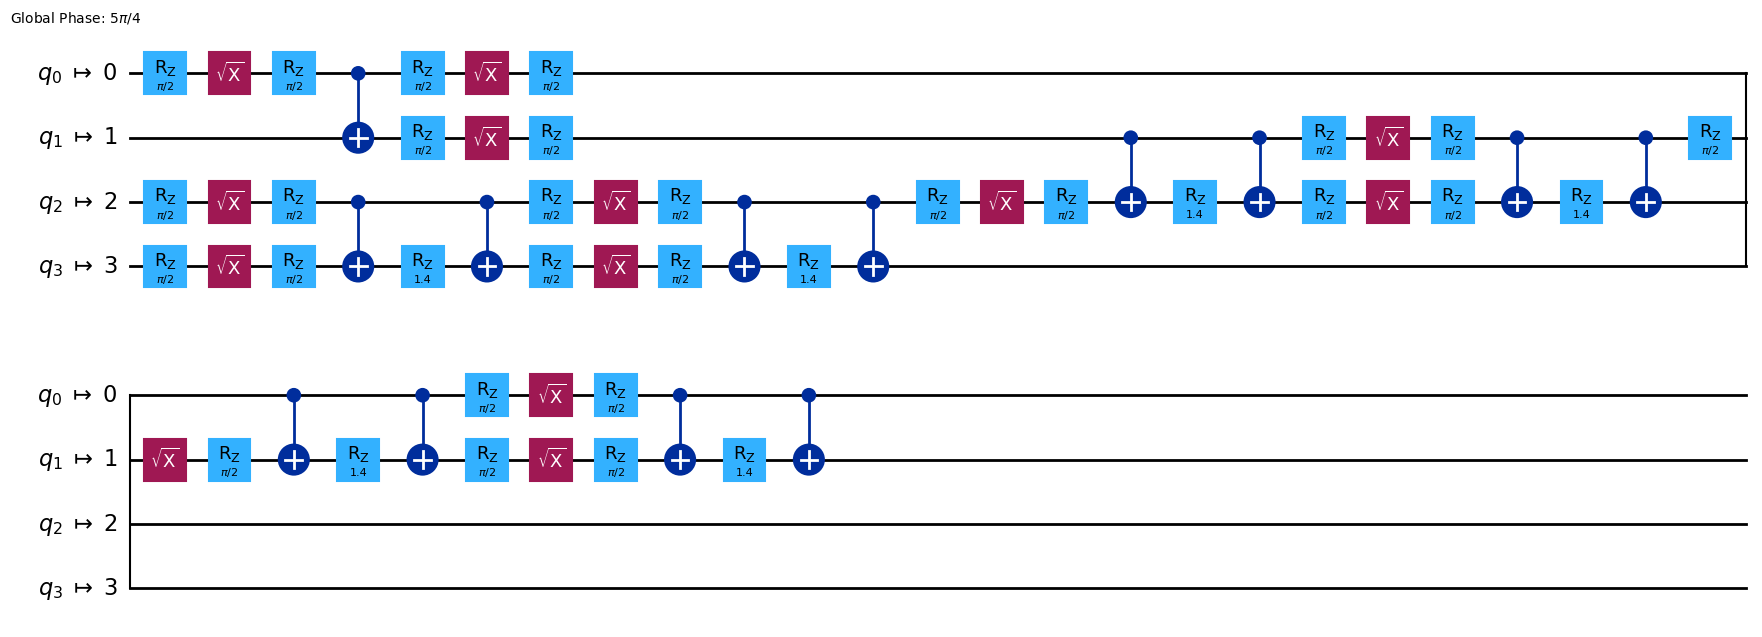

In [33]:
qc_transpiled_1.draw("mpl")

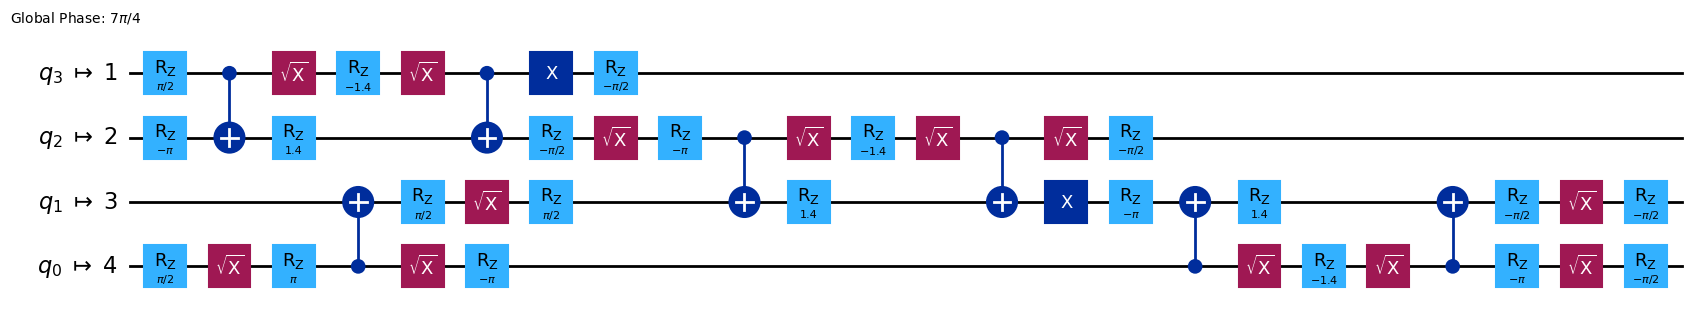

In [34]:
qc_transpiled_3.draw("mpl")

Other Visualizations:
1. DAGCircuit representation

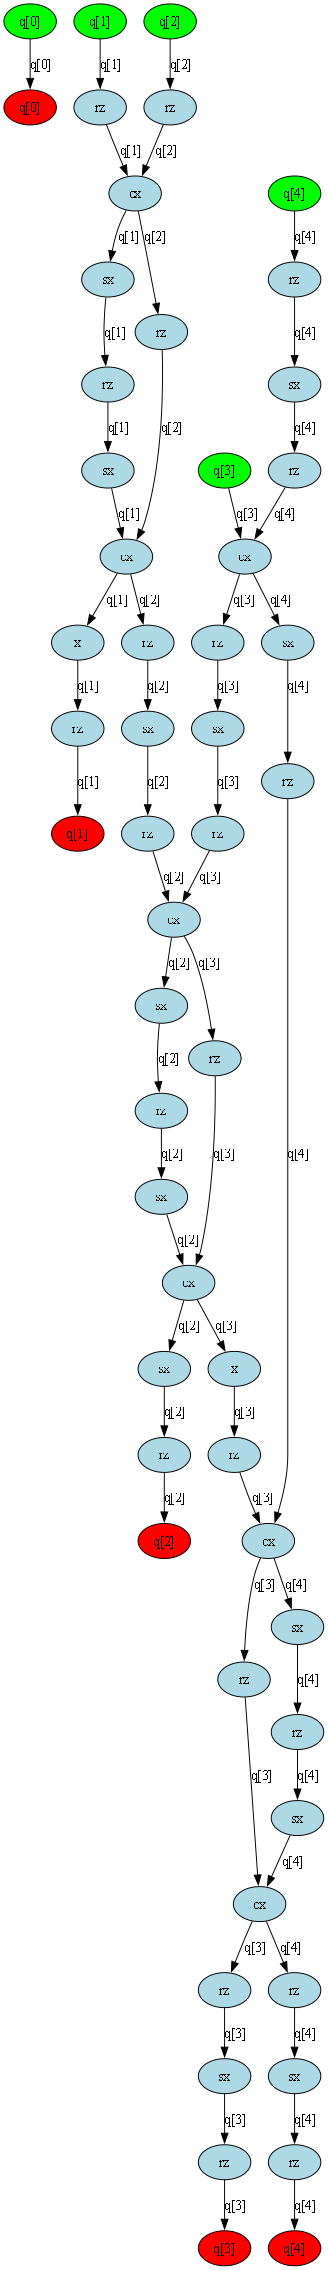

In [35]:
dag3 = circuit_to_dag(qc_transpiled_3)
dag3.draw()

2. Quantum Info

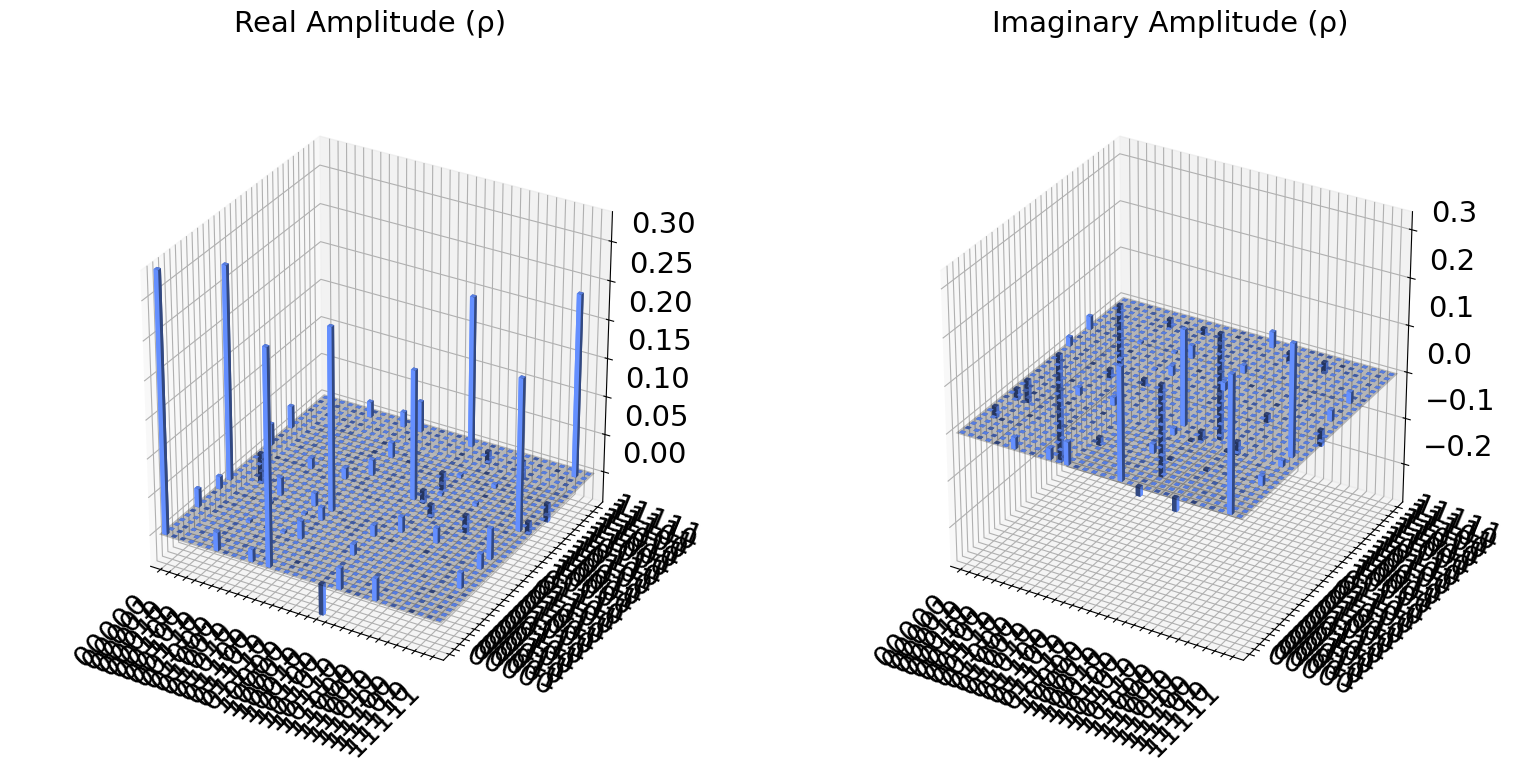

In [36]:
state = Statevector(qc_transpiled_3)
plot_state_city(state)

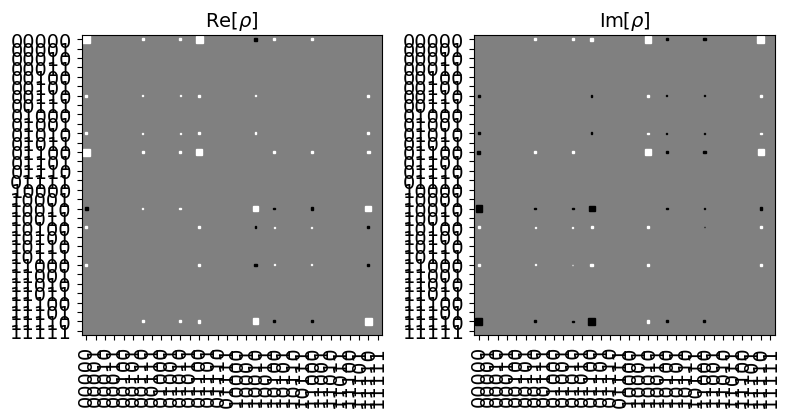

In [37]:
plot_state_hinton(state)

In [38]:
matrix = DensityMatrix(qc_transpiled_3)
matrix.draw("latex")

<IPython.core.display.Latex object>

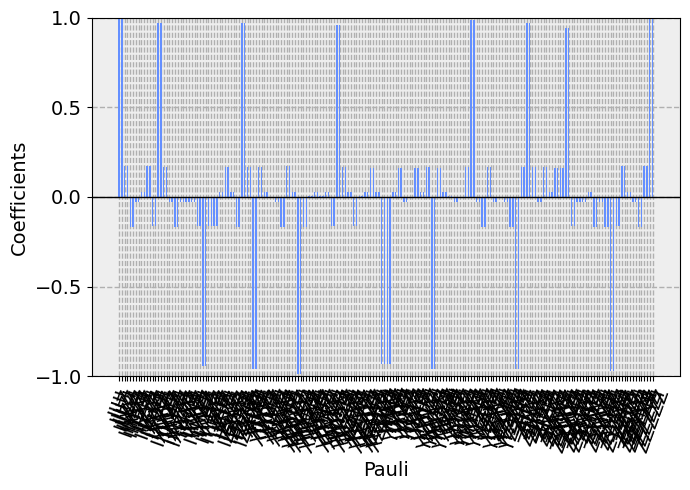

In [39]:
plot_state_paulivec(matrix)

3. Hardware Visualization

In [40]:
coupling_map = backend.coupling_map
print(coupling_map)

[[0, 1], [1, 0], [1, 2], [2, 1], [2, 3], [3, 2], [3, 4], [4, 3]]


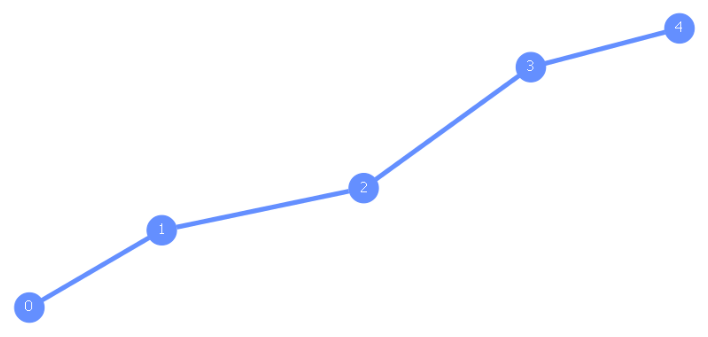

In [41]:
plot_coupling_map(num_qubits = 133, coupling_map = list(coupling_map), qubit_coordinates=None)

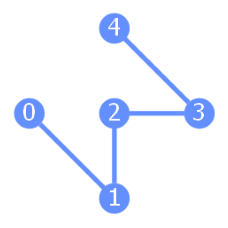

In [42]:
plot_gate_map(backend)

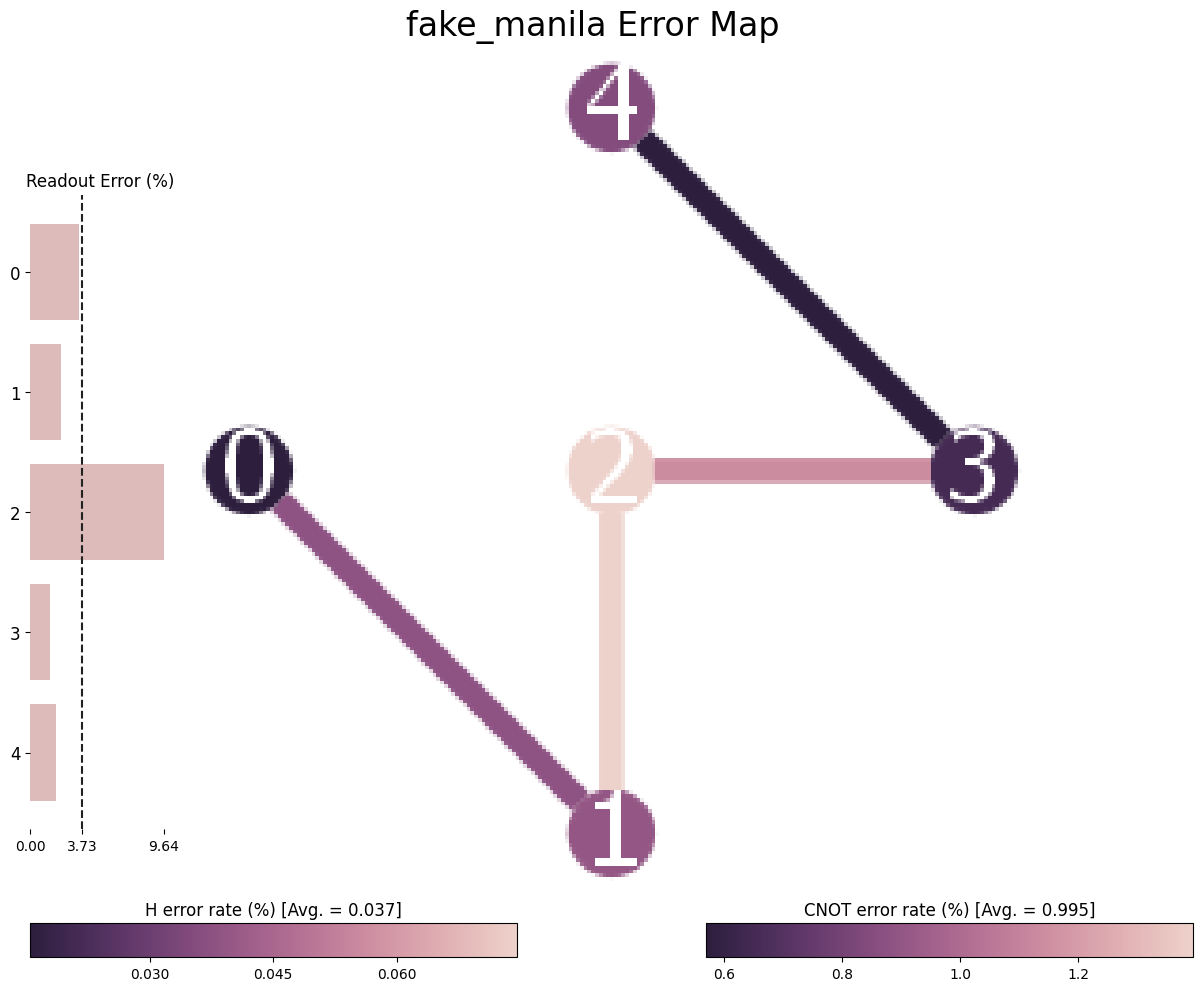

In [43]:
plot_error_map(backend)

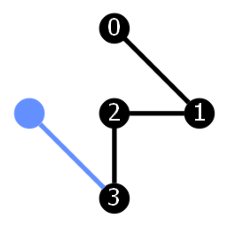

In [44]:
plot_circuit_layout(qc_transpiled_3, backend)

4. Visualizing the Pass Manager

In [56]:
pm = generate_preset_pass_manager(optimization_level=3)
# pass_manager_drawer(pm) {Try to see if it works, sometimes doesn't work on some Window's environments}

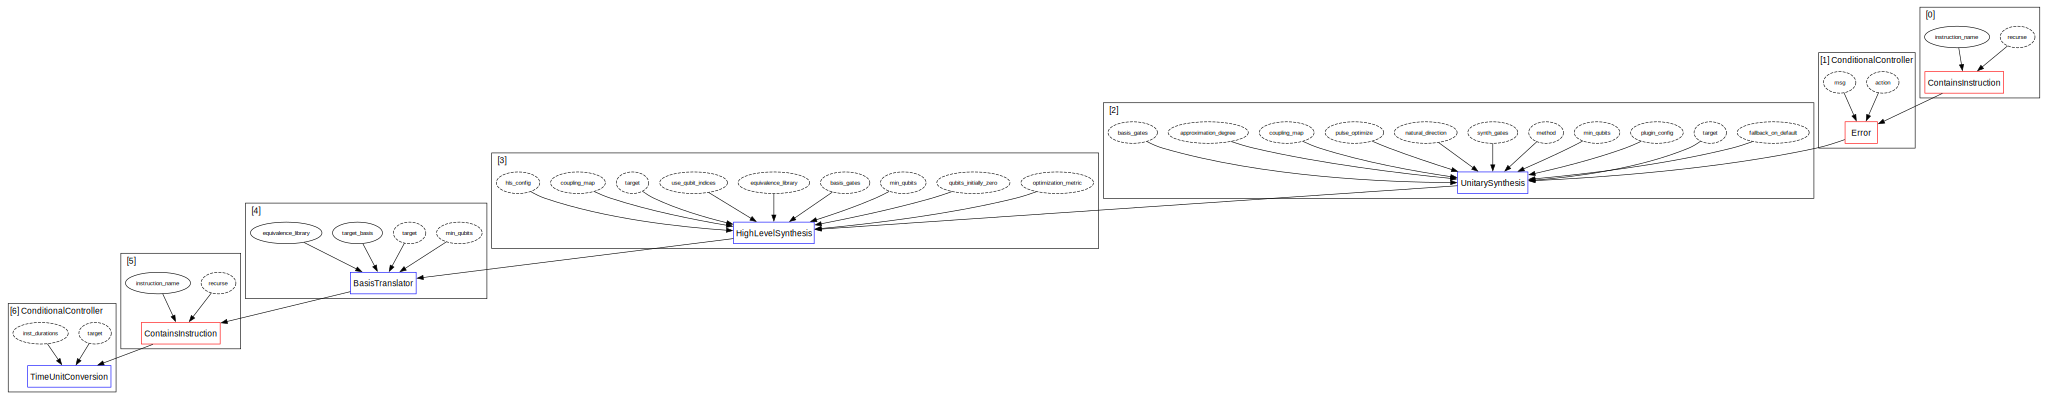

In [60]:
# IF THE DRAWER DOESN'T WORK:
from graphviz import Source
pass_manager_drawer(pm, filename="pass_manager.dot", raw=True)
with open("pass_manager.dot") as f:
    dot_graph = f.read()
Source(dot_graph)

In [61]:
pm = generate_preset_pass_manager(optimization_level=0)
# pass_manager_drawer(pm) {Try to see if it works, sometimes doesn't work on some Window's environments}

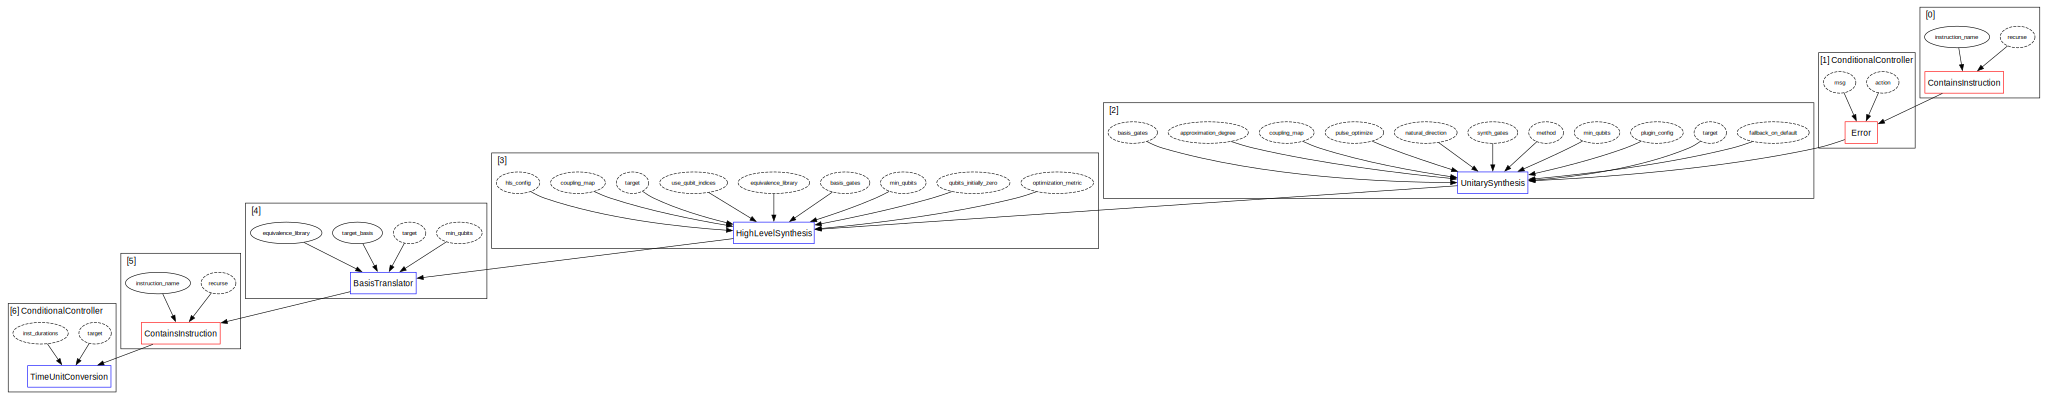

In [62]:
# IF THE DRAWER DOESN'T WORK
pass_manager_drawer(pm, filename="pass_manager.dot", raw=True)
with open("pass_manager.dot") as f:
    dot_graph = f.read()
Source(dot_graph)

NOW, to actually execute the transpiled quantum circuit, we the `EstimatorV2` Primitive for the Hamiltonian `H` to obtain the average energy level of the system:

In [66]:
# Define Estimator
estimator = EstimatorV2(mode=backend)
estimator.options.default_shots = 500000

# Define the new Hamiltonian
H_new = H.apply_layout(layout=qc_transpiled_3.layout) # Since the transpiled circuit uses 5 qubits in a different layout 

# Define the PUB (Primitive Unified Block)
# tuple: (circuit, observables, parameter_values{optional})
pub = (qc_transpiled_3, H_new)

In [68]:
# Execute the job on the FakeManilaV2 Backend:
job = estimator.run([pub])
result = job.result()

# Obtain the expectation value (evs) of the Hamiltonian (average energy level of the system)
energy = result[0].data.evs
print(f"Energy: {energy}")

Energy: 1.892448


In [70]:
# Using the StatevectorEstimator directly:
exact_estimator = StatevectorEstimator()
job = exact_estimator.run([(qc_transpiled_3, H_new)])
exact_energy = job.result()[0].data.evs
print("Exact energy (theoretical):", exact_energy)

Exact energy (theoretical): 2.452123769369386


* We see this deviation in answers because of hardware noise (Manila is an old processor, ~6 years old).
* We can expect better results using modern hardware with less noise (in fact in the Fault-tolerance regime ~2029 we can just say there is no noise).

Let's try using a noiseless backend (AerSimulator):

In [72]:
# Pick AerSimulator as the backend (noiseless):
backend = AerSimulator()

In [74]:
# Rest of the code is the same:
estimator = EstimatorV2(mode=backend)
estimator.options.default_shots = 100000

H_new = H.apply_layout(layout=qc_transpiled_3.layout)
pub = (qc_transpiled_3, H_new)

job = estimator.run([pub])
result = job.result()

energy = result[0].data.evs
print(f"Energy: {energy}")

Energy: 2.4544354556454437


* As we see, we converge to a better value (much closer to the theoretical).
* For a 4-qubit system it's easy to use an exact simulation, but this becomes exponentially difficult as the qubits increase (In fact, for an $n$-qubit system, we would need a $2^n$ dimensional Hamiltonian matrix for exact estimation using `StatevectorEstimator`).
* So Quantum computers and circuits are required for large, realistic material/chemistry applications.